# Architecture testing with supervised learning

In this notebook I want to test the well-functioning of the various architectures proposed for the actor and the critic.

The setup is the following:
1. Generate a series of states s
2. Use optimal policy to associate them with an optimal action* a 
3. Train only the actor architecture with cross-entropy loss

*one could also use the optimal probabilities if known, but anyway if done in an unbiased way, the sampling procedure will be enough to learn stochastic policies.

Since we already have an optimal policy implemented for sandbox environment and all the code ready for playing episodes, we can build a training set starting from trajectories and then sample simple (s,a) tuples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from Utils import test_env, utils
from Utils.supervised import *

from RelationalModule import AC_networks as nets
from RelationalModule.MLP_AC_networks import Actor

from importlib import reload

# Coordinate state representation

In [2]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True)

In [4]:
lr = 5e-4
n_epochs = 50
coord_net = Actor(action_space=4, observation_space=5, hiddens=[64,32,16])

In [5]:
# results = supervised_training(coord_net, lr, n_epochs, 100000, game_params)

In [6]:
state_set, action_set = create_action_state_set(game_params, size=10000, get_probs=True)

In [7]:
action_set[0] # now are probabilities instead of actions

array([0.5, 0. , 0. , 0.5])

In [8]:
results = supervised_training(coord_net, lr, n_epochs, 100000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2195 took: 2.86s  Val. loss: 0.1596
Epoch 2, 100% 	 Train loss: 0.1333 took: 1.23s  Val. loss: 0.1186
Epoch 3, 100% 	 Train loss: 0.1136 took: 1.58s  Val. loss: 0.1084
Epoch 4, 100% 	 Train loss: 0.1051 took: 1.57s  Val. loss: 0.1013
Epoch 5, 100% 	 Train loss: 0.0986 took: 1.64s  Val. loss: 0.0955
Epoch 6, 100% 	 Train loss: 0.0928 took: 1.66s  Val. loss: 0.0898
Epoch 7, 100% 	 Train loss: 0.0880 took: 1.26s  Val. loss: 0.0852
Epoch 8, 100% 	 Train loss: 0.0839 took: 1.24s  Val. loss: 0.0813
Epoch 9, 100% 	 Train loss: 0.0805 took: 1.22s  Val. loss: 0.0789
Epoch 10, 100% 	 Train loss: 0.0782 took: 1.22s  Val. loss: 0.0764
Epoch 11, 100% 	 Train loss: 0.0765 took: 1.23s  Val. loss: 0.0749
Epoch 12, 100% 	 Train loss: 0.0753 took: 1.23s  Val. loss: 0.0740
Epoch 13, 100% 	 Train loss: 0.0746 took: 1.24s  Val. loss: 0.0734
Epoch 14, 100% 	 Train loss: 0.0739 took: 1.33s  Val. loss: 0.0732
Epoch 15, 100% 	 Train loss: 0.0734 took: 1.71s  Val. loss: 0.0727
Epoc

In [9]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [3]:
import string
import random

save = False
keywords = ['coord','KL_div','10by10','100000-samples','50-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Nothing saved


In [4]:
load_dir = 'Results/Sandbox/Supervised/'
coord_trained_net = torch.load(load_dir+"net_S_coord_10by10_100000-samples_20-epochs_lr5e-4_XVOF")
#coord_trained_net = torch.load(load_dir+"net_S_coord_KL_div_10by10_100000-samples_50-epochs_lr5e-4_EPWF")

In [12]:
# state set = [x_agent, y_agent, x_goal, y_goal, near_boundary]
X, Y = env.boundary[0], env.boundary[1]
x_agent = (state_set[:,0]*X).astype(int)
y_agent = (state_set[:,1]*Y).astype(int)
x_goal = (state_set[:,2]*X).astype(int)
y_goal = (state_set[:,3]*Y).astype(int)

possible_combinations = (X**2)*(Y**2)
print("Possible number of states: ", possible_combinations)


Possible number of states:  10000


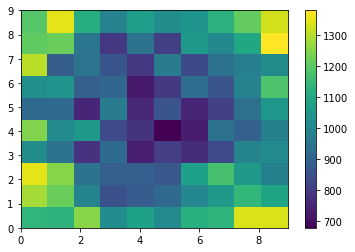

In [13]:
plt.hist2d(x_goal, y_goal, bins = [X,Y])
plt.colorbar()
plt.show()

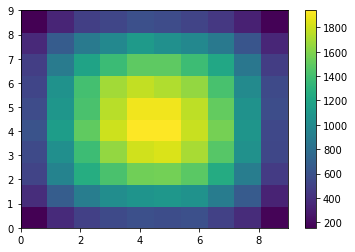

In [14]:
plt.hist2d(x_agent, y_agent, bins = [X,Y])
plt.colorbar()
plt.show()

The dataset is unbalanced in the experience... 

In [15]:
def random_start(X=10, Y=10):
    s1, s2 = np.random.choice(X*Y, 2, replace=False)
    initial = [s1//X, s1%X]
    goal = [s2//X, s2%X]
    return initial, goal

In [12]:
initials = []
goals = []
N = 100000
for i in range(N):
    initial, goal = random_start(10,10)
    initials.append(initial)
    goals.append(goal)

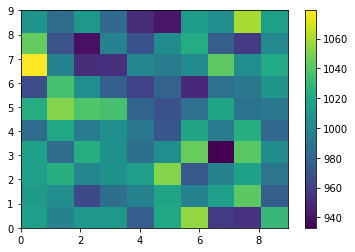

In [13]:
initials = np.array(initials)
x_initials = initials[:,0]
y_initials = initials[:,1]
plt.hist2d(x_initials, y_initials, bins = [10,10])
plt.colorbar()
plt.show()

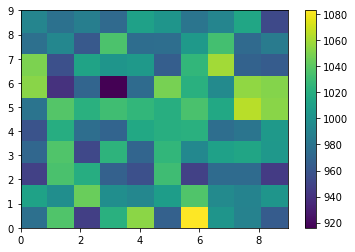

In [14]:
goals = np.array(goals)
x_goals = goals[:,0]
y_goals = goals[:,1]
plt.hist2d(x_goals, y_goals, bins = [10,10])
plt.colorbar()
plt.show()

This is not because of the initial conditions, but probably is due to the fact that all info that we collect comes from real trajectories! So basically we see more the goals in the corners because it takes more time to get there on average, so they are present in more frames. At the same time, we see the agent more in the center probably because it's the place where it passes more times. A work around on this is to avoid playing the whole episode and just taking the initial state and the optimal action in that state.

In [6]:
env = test_env.Sandbox(**game_params)

# choose state and see if the agent classifies it correctly
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# vertical direction is x (first coordinate)
# horizontal direction is y (second coordinate)
state = [4,2]
goal = [4,4]
env.state = state
env.goal = goal
enc_state = env.enc_to_coord()
x = torch.tensor(enc_state).float().to(device)
log_probs = coord_trained_net(x)
probs = torch.exp(log_probs)
for i in range(4):
    print("Action "+env.action_dict[i]+" taken with p = %.2f"%(probs[i]*100))
print(env)

Action Right taken with p = 73.04
Action Left taken with p = 0.54
Action Down taken with p = 10.81
Action Up taken with p = 15.62
Use greyscale state:  False
Use coordinate state:  True
Use one hot encoding state:  False
Boundary:  [10 10]
Initial position:  [0 0]
Current position:  [4, 2]
Goal position:  [4, 4]
Optimal actions: 
	Right
Greyscale representation: 
 [[[3 3 3 3 3 3 3 3 3 3 3 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 1 0 2 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 3 3 3 3 3 3 3 3 3 3 3]]]



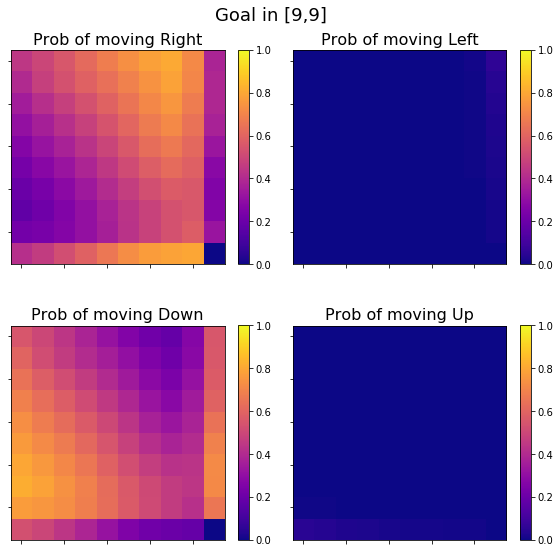

In [50]:
goal = [9,9]
probs = plot_decision_map(env, coord_trained_net, goal)

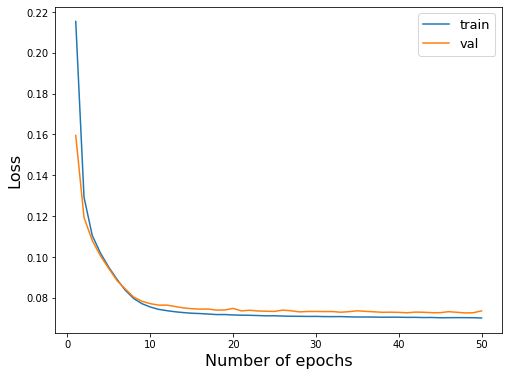

In [21]:
%matplotlib inline
plot_results(train_loss, val_loss)

In [9]:
coord_agent = OheAgent(coord_trained_net, device='cuda')

In [12]:
game_params['initial'] = [0,0]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


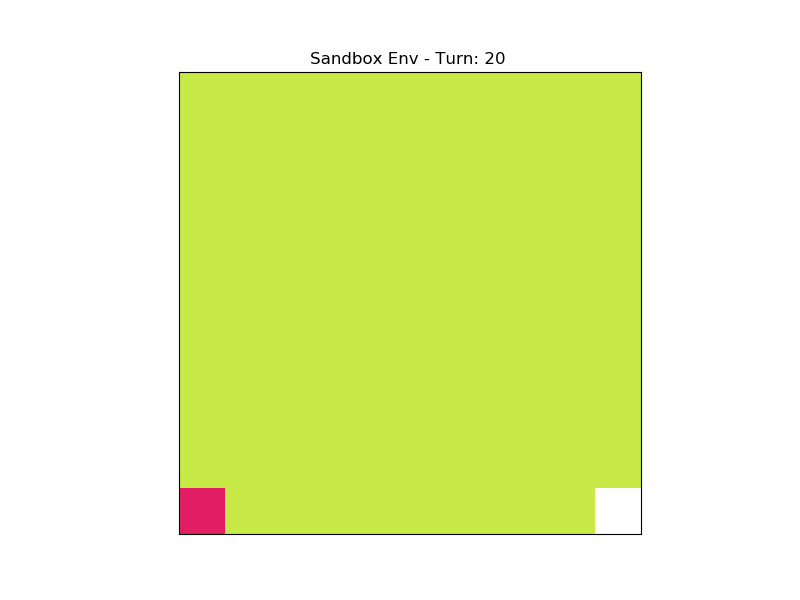

In [13]:
%matplotlib notebook
utils.render(coord_agent, env=env, greedy=True)

%matplotlib inline

## Difference of coordinate

In [14]:
def supervised_training_v1(net, lr, n_epochs, n_samples, game_params, get_probs=False):
    env = test_env.Sandbox(**game_params)
    print("\nCreating dataset...")
    state_dataset, action_set = create_action_state_set(game_params, size=n_samples, get_probs=get_probs)
    state_set = np.zeros((n_samples,2))
    state_set[:,0] = state_dataset[:,2]-state_dataset[:,0]
    state_set[:,1] = state_dataset[:,3]-state_dataset[:,1]
    train_loader, val_loader, test_loader = prepare_dataset(state_set, action_set, 0.8, 0.2)
    dataloader_dict = dict(train_loader=train_loader,
                           val_loader=val_loader,
                           test_loader=test_loader)
    print("\nTraining network...")
    net, train_loss, val_loss = train_NN(net, lr, n_epochs, train_loader, val_loader, 
                                         return_model=True, KL_loss=get_probs)
    
    return net, train_loss, val_loss, dataloader_dict, state_set, action_set, env

In [15]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True)

In [17]:
lr = 5e-4
n_epochs = 50
diff_coord_net = Actor(action_space=4, observation_space=2, hiddens=[64,32,16])

In [18]:
results = supervised_training_v1(diff_coord_net, lr, n_epochs, 100000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2079 took: 1.82s  Val. loss: 0.1438
Epoch 2, 100% 	 Train loss: 0.1235 took: 1.71s  Val. loss: 0.1158
Epoch 3, 100% 	 Train loss: 0.1062 took: 1.85s  Val. loss: 0.1017
Epoch 4, 100% 	 Train loss: 0.0955 took: 1.76s  Val. loss: 0.0933
Epoch 5, 100% 	 Train loss: 0.0897 took: 1.73s  Val. loss: 0.0893
Epoch 6, 100% 	 Train loss: 0.0874 took: 1.77s  Val. loss: 0.0878
Epoch 7, 100% 	 Train loss: 0.0866 took: 1.77s  Val. loss: 0.0876
Epoch 8, 100% 	 Train loss: 0.0864 took: 1.77s  Val. loss: 0.0870
Epoch 9, 100% 	 Train loss: 0.0861 took: 1.77s  Val. loss: 0.0869
Epoch 10, 100% 	 Train loss: 0.0861 took: 1.75s  Val. loss: 0.0868
Epoch 11, 100% 	 Train loss: 0.0860 took: 1.83s  Val. loss: 0.0869
Epoch 12, 100% 	 Train loss: 0.0860 took: 1.62s  Val. loss: 0.0867
Epoch 13, 100% 	 Train loss: 0.0859 took: 1.77s  Val. loss: 0.0867
Epoch 14, 100% 	 Train loss: 0.0859 took: 1.59s  Val. loss: 0.0867
Epoch 15, 100% 	 Train loss: 0.0859 took: 1.79s  Val. loss: 0.0866
Epoc

In [19]:
diff_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [20]:
def plot_decision_map_v1(env, net, goal):
    env.goal = goal
    
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    probabilities = []
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            if [x,y] != goal:
                env.state = [x,y]
                encoded_state = env.enc_to_coord()
                enc_state = np.array([encoded_state[2]-encoded_state[0],encoded_state[3]-encoded_state[1]])
                enc_state = torch.tensor(enc_state).float().to(device)
                log_probs = net(enc_state).squeeze()
                probs = torch.exp(log_probs).cpu().detach().numpy()
                
            else:
                probs = np.zeros(env.n_actions)
            probabilities.append(probs)
            
    probs = np.array(probabilities).reshape((env.boundary[0],env.boundary[1],-1))
    
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Goal in [%d,%d]'%(goal[0],goal[1]), fontsize=18, y=1, x=0.48)
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)
    axes = [ax1, ax2, ax3, ax4]
    for i, ax in enumerate(axes):
        im = ax.imshow(probs[:,:,i], cmap='plasma', vmin=0, vmax=1)
        ax.set_title("Prob of moving "+env.action_dict[i], fontsize=16)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.colorbar(im, ax=ax, shrink=0.77)
    plt.tight_layout()
    
    return probs

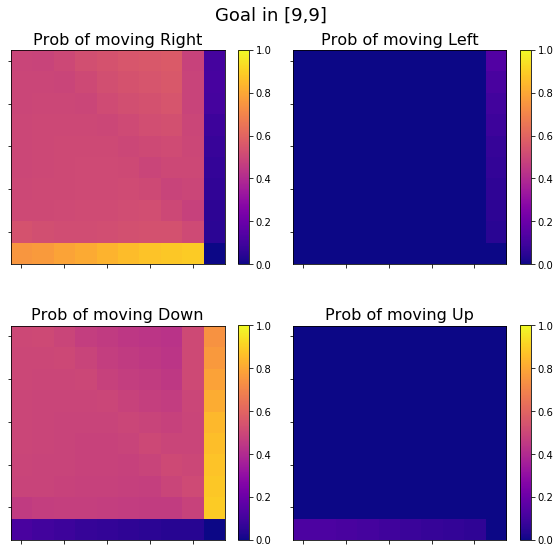

In [51]:
goal = [9,9]
probs = plot_decision_map_v1(env, diff_trained_net, goal)

## One Hot Encoded state representation

In [37]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [2,2]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [46]:
lr = 5e-4
n_epochs = 20
ohe_net = nets.OheActor(action_space=4, map_size=5) #check mapsize

In [47]:
%%time
results = supervised_training(ohe_net, lr, n_epochs, 10000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 10% 	 Train loss: 0.3374 took: 0.11s  

/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.2721 took: 1.11s  Val. loss: 0.2563
Epoch 2, 100% 	 Train loss: 0.2449 took: 1.15s  Val. loss: 0.2300
Epoch 3, 100% 	 Train loss: 0.2157 took: 1.13s  Val. loss: 0.2022
Epoch 4, 100% 	 Train loss: 0.1924 took: 1.13s  Val. loss: 0.1823
Epoch 5, 100% 	 Train loss: 0.1756 took: 1.15s  Val. loss: 0.1665
Epoch 6, 100% 	 Train loss: 0.1630 took: 1.13s  Val. loss: 0.1551
Epoch 7, 100% 	 Train loss: 0.1540 took: 1.14s  Val. loss: 0.1554
Epoch 8, 100% 	 Train loss: 0.1478 took: 1.14s  Val. loss: 0.1432
Epoch 9, 100% 	 Train loss: 0.1420 took: 1.12s  Val. loss: 0.1370
Epoch 10, 100% 	 Train loss: 0.1370 took: 1.10s  Val. loss: 0.1382
Epoch 11, 100% 	 Train loss: 0.1337 took: 1.14s  Val. loss: 0.1324
Epoch 12, 100% 	 Train loss: 0.1305 took: 1.12s  Val. loss: 0.1357
Epoch 13, 100% 	 Train loss: 0.1299 took: 1.10s  Val. loss: 0.1287
Epoch 14, 100% 	 Train loss: 0.1278 took: 1.10s  Val. loss: 0.1344
Epoch 15, 100% 	 Train loss: 0.1257 took: 1.11s  Val. loss: 0.1268
Epoc

0.1106

In [48]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

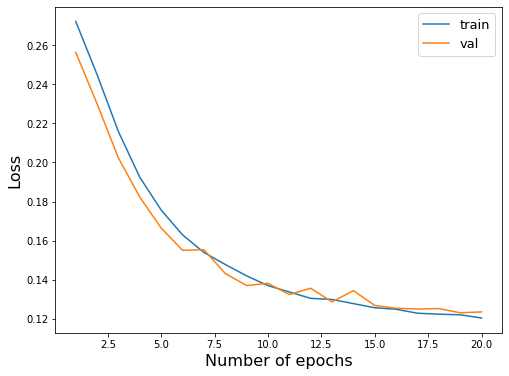

In [49]:
plot_results(train_loss, val_loss)

As a result I don't expect a loss of 0, because in many states there are 2 possible choices to make, e.g. if I have to go right and down, I can equally go down and then left, so each choice can be taken with arbitrary probability, as long as the choice remains between the two actions (said in other words, the probability of choosing one of those 2 actions is 1).

Anyway, the loss function is the average of - log of the probability of coosing the optimal action, so will be 0 if all actions are certain and the network classifies all of them correctly, and will be -log(0.5) = 0.693 if every action is selected with 0.5 probability. So for sure an optimal classifier should score less than 0.693 to be said so (because there are states where a single optimal action is possible).

Actually if we assume all states to be equally probable (that is a bad assumption actually, because we will always find more states where the agent is near the goal if the states are collected from optimal trajectories), we can make a computation to see how much the optimal loss should be.

Calling X the linear size of the map, we have 2X-2 states out of X^2 - 1 in which there is only an optimal action, and X^2 - 1 - 2X + 2 in which there are 2. 

$$ L(X) = -\frac{2X-2}{X^2 - 1}log(1) - \frac{X^2 - 2X + 1}{X^2 - 1}log(0.5) = \frac{X-1}{X+1}\cdot0.69$$

hence L(5) = 0.46.

This training is far from optimal and that probably depends on the fact that is failing to recognize corners and walls...

### From supervised to real actor

To test how the training looks like, we can use the net to see if the result is optimal or not.

In [50]:
ohe_agent = OheAgent(trained_net, device='cuda')

In [51]:
game_params['initial'] = [0,0]
game_params['goal'] = [3,3]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


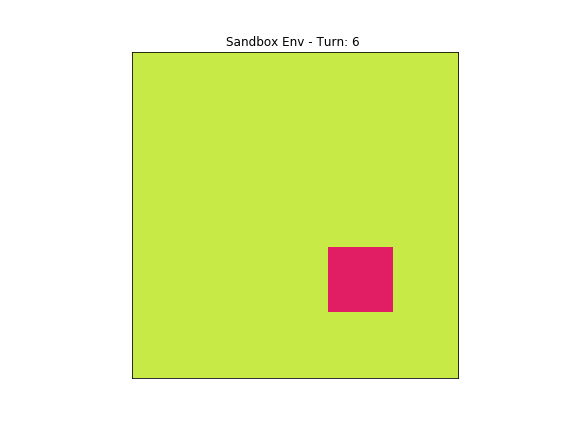

In [52]:
%matplotlib notebook
utils.render(ohe_agent, env=env, greedy=False)

%matplotlib inline

# Relational agent

In [22]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [23]:
chosen_HPs = torch.load("Results/Sandbox/Supervised/best_HP_S_chosen-residual_UMUT")

In [29]:
lr = 5e-4
n_epochs = 50

HPs = dict(n_features=64, n_heads=4,  n_attn_modules=2, feature_hidden_dim=128, feature_n_residuals=2)
relational_actor_net = nets.GatedBoxWorldActor(action_space=4, **chosen_HPs)

In [30]:
torch.cuda.empty_cache()

In [31]:
results = supervised_training(relational_actor_net, lr, n_epochs, 10000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 0.2603 took: 3.48s  Val. loss: 0.2543
Epoch 2, 100% 	 Train loss: 0.2589 took: 3.43s  Val. loss: 0.2533
Epoch 3, 100% 	 Train loss: 0.2576 took: 3.43s  Val. loss: 0.2485
Epoch 4, 100% 	 Train loss: 0.2120 took: 3.43s  Val. loss: 0.1611
Epoch 5, 100% 	 Train loss: 0.1497 took: 3.44s  Val. loss: 0.1204
Epoch 6, 100% 	 Train loss: 0.1068 took: 3.44s  Val. loss: 0.0977
Epoch 7, 100% 	 Train loss: 0.0910 took: 3.44s  Val. loss: 0.0831
Epoch 8, 100% 	 Train loss: 0.0848 took: 3.45s  Val. loss: 0.0863
Epoch 9, 100% 	 Train loss: 0.0842 took: 3.44s  Val. loss: 0.0812
Epoch 10, 100% 	 Train loss: 0.0805 took: 3.44s  Val. loss: 0.0769
Epoch 11, 100% 	 Train loss: 0.0793 took: 3.45s  Val. loss: 0.0782
Epoch 12, 100% 	 Train loss: 0.0790 took: 3.54s  Val. loss: 0.0800
Epoch 13, 100% 	 Train loss: 0.0769 took: 3.45s  Val. loss: 0.0794
Epoch 14, 100% 	 Train loss: 0.0792 took: 3.45s  Val. loss: 0.0

0.0749

In [32]:
relational_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [33]:
import string
import random

save = True
keywords = ['relational','chosen-HPs','KL_div','10by10','10000-samples','50-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(relational_trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/Supervised/S_relational_chosen-HPs_KL_div_10by10_10000-samples_50-epochs_lr5e-4_ZJUB


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__nam

In [34]:
load_dir = 'Results/Sandbox/Supervised/'
#relational_trained_net = torch.load(load_dir+"net_S_relational_10by10_100000-samples_50-epochs_lr5e-4_CQBC")
relational_trained_net = torch.load(load_dir+"net_S_relational_chosen-HPs_KL_div_10by10_10000-samples_50-epochs_lr5e-4_ZJUB")

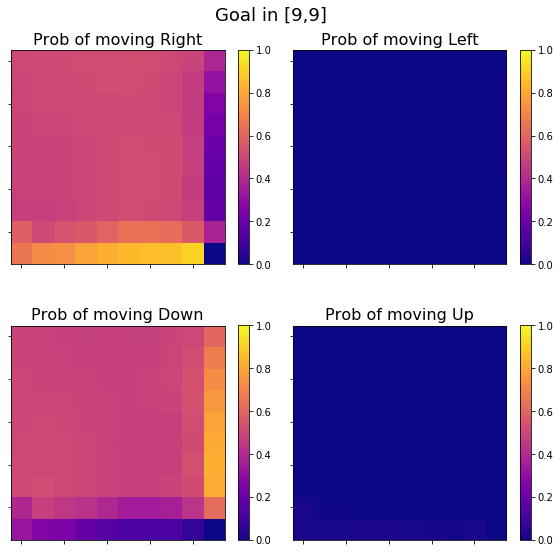

In [36]:
goal = [9,9]
probs = plot_decision_map(env, relational_trained_net, goal, coord=False)

In [37]:
relational_agent = OheAgent(relational_trained_net, device='cuda')

In [38]:
game_params['initial'] = [0,0]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


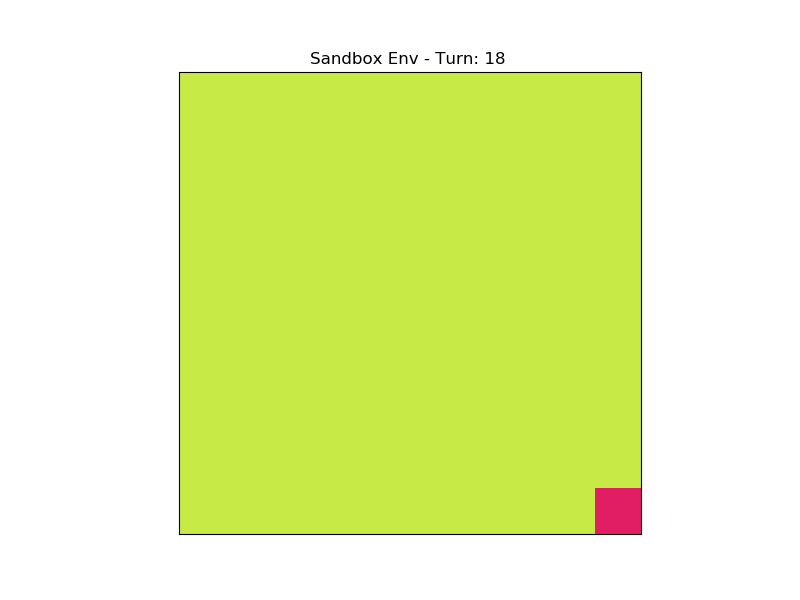

In [39]:
%matplotlib notebook
utils.render(relational_agent, env=env, greedy=True)

%matplotlib inline

# Multiplicative net

In [40]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 25

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [41]:
best_HPs = torch.load("Results/Sandbox/Supervised/best_HP_S_best-multiconvnet_FQXZ")

In [42]:
lr = 5e-3
n_epochs = 100

HPs = dict(linear_size = X+2,
           in_channels = 3,
           hidden_channels=[12],
           max_pool_size = 3,
           n_features = 16
          )

multi_actor_net = nets.MultiplicativeActor(action_space=4, linear_size = X+2, version='v1', 
                                           plug_off=True, **best_HPs)

In [5]:
results = supervised_training(multi_actor_net, lr, n_epochs, 50000, game_params, get_probs=True)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1, 100% 	 Train loss: 0.1665 took: 5.36s  Val. loss: 0.1088
Epoch 2, 100% 	 Train loss: 0.0940 took: 4.14s  Val. loss: 0.0821
Epoch 3, 100% 	 Train loss: 0.0823 took: 4.11s  Val. loss: 0.0814
Epoch 4, 100% 	 Train loss: 0.0782 took: 4.14s  Val. loss: 0.0767
Epoch 5, 100% 	 Train loss: 0.0755 took: 5.21s  Val. loss: 0.0753
Epoch 6, 100% 	 Train loss: 0.0746 took: 5.77s  Val. loss: 0.0753
Epoch 7, 100% 	 Train loss: 0.0737 took: 5.75s  Val. loss: 0.0743
Epoch 8, 100% 	 Train loss: 0.0729 took: 5.76s  Val. loss: 0.0738
Epoch 9, 100% 	 Train loss: 0.0725 took: 5.75s  Val. loss: 0.0733
Epoch 10, 100% 	 Train loss: 0.0721 took: 5.76s  Val. loss: 0.0740
Epoch 11, 100% 	 Train loss: 0.0720 took: 5.93s  Val. loss: 0.0719
Epoch 12, 100% 	 Train loss: 0.0715 took: 5.99s  Val. loss: 0.0737
Epoch 13, 100% 	 Train loss: 0.0711 took: 5.98s  Val. loss: 0.0739
Epoch 14, 100% 	 Train loss: 0.0708 took: 5.99s  Val. loss: 0.0726
Epoch 15, 100% 	 Train loss: 0.0709 took: 5.81s  Val. loss: 0.0727
Epoc

0.0674 - 0.0706

In [11]:
multi_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [27]:
import string
import random

save = True
keywords = ['multiplicative','convolutional','best-HPs','v0'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised/'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+"net_"+filename)
    torch.save(multi_trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/Supervised/net_S_multiplicative_convolutional_best-HPs_v0_JPBZ


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiplicativeActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiplicativeConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj

In [43]:
load_dir = 'Results/Sandbox/Supervised/'
multi_trained_net = torch.load(load_dir+"net_S_multiplicative_convolutional_best-HPs_v0_JPBZ")

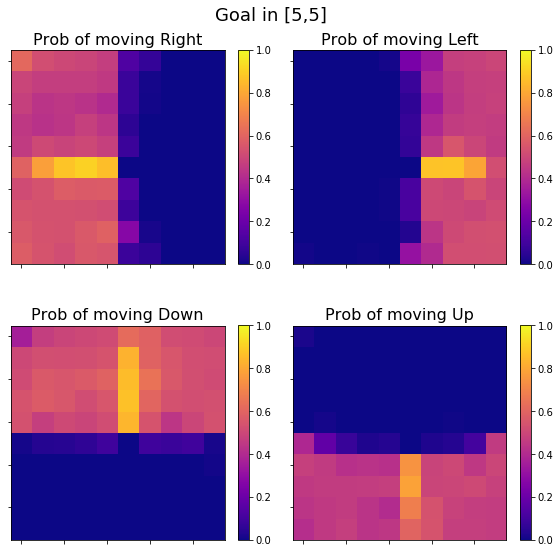

In [52]:
goal = [5,5]
probs = plot_decision_map(env, multi_trained_net, goal, coord=False)

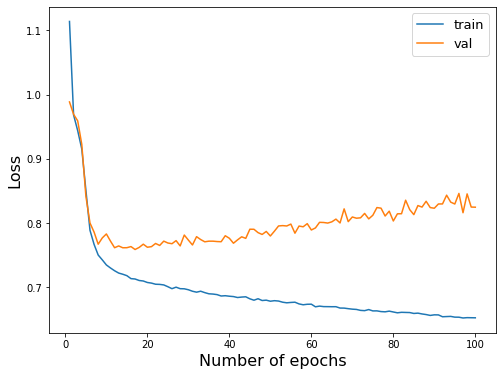

In [13]:
plot_results(train_loss, val_loss)

In [46]:
multi_agent = OheAgent(multi_trained_net, device='cuda')

In [47]:
game_params['initial'] = [0,0]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


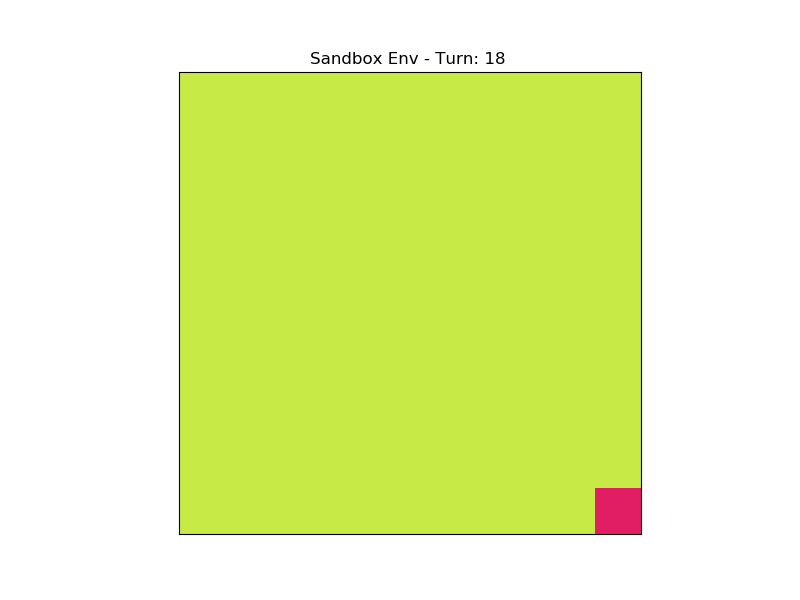

In [48]:
%matplotlib notebook
utils.render(multi_agent, env=env, greedy=False)

%matplotlib inline